Transformer
```
RNN/LSTM 의 한계
  순차처리 : 단어를 하나씩 읽어서 문맥을 이해, 초기 정보 잊음
  병렬화 불가 : GPU를 활용한 빠른 학습이 불가
Transformer 장점
  병렬 처리
  self-attention  : 단어간의 관계를 직접계산 긴 문맥도 잘 파악
Transformer의 전체 구조
  Encoder : 입력문장을 벡터로변환  "영화가 재미있다"->의미벡터
  Decoder : 출력문장생성, 번역.
    구성 : 인코더와 유사 + masked self-attention + encoder-decoder attention
  self-attention  : 단어간 중요도를 계산 "영화가" "재미있다" 강하게 연될
Positional Encoding : 단어의 위치를 나타내는 벡터를 추가
  방식 : 사인/코사인 함수로 고정된 위치벡터를 생성
```

self attention layer 구현




In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from typing import Tuple
class SelfAttention(nn.Module):
  def __init__(self,embed_dim:int, num_heads:int  = 1):
    super().__init__()
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.head_dim = embed_dim // num_heads  # 각 헤드가 처리할 feature 크기
    self.query = nn.Linear(embed_dim, embed_dim)
    self.key = nn.Linear(embed_dim, embed_dim)
    self.value = nn.Linear(embed_dim, embed_dim)
    # softmax 전에 값이 너무커지는 것을 방지해서 학습 안정화
    self.scale = torch.sqrt(torch.FloatTensor([self.head_dim]))
  def forward(self, x:torch.Tensor)->Tuple[torch.Tensor, torch.Tensor]:
    batch_size,seq_len,embed_dim = x.size()  # x.shape
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)
    # 멀티해드 분할 (batch_size, head수, seq길이,head차원) 형태로 분할
    # seq_len, num_heads 축을 swap --> 계산할때 해드별로 묶어서 편하게하려고
    Q = Q.view(batch_size,seq_len,self.num_heads,self.head_dim).transpose(1,2)
    K = K.view(batch_size,seq_len,self.num_heads,self.head_dim).transpose(1,2)
    V = V.view(batch_size,seq_len,self.num_heads,self.head_dim).transpose(1,2)
    # 어텐션 스코어(얼마나 주목할지)
    scores = torch.matmul(Q, K.transpose(-2,-1)) / self.scale
    attn_weight = torch.softmax(scores,dim=-1)  # 0~1 확률 가장중요한 토큰에 높은 점수를 주기위해서
    out = torch.matmul(attn_weight,V)
    # 헤드들을 다시 합쳐서 원래 차원으로 복원
    # batch_size, num_head, seq_len, head_dim -->
    # batch_size, seq_len, num_head, head_dim
    # contiguous 메모리 재 정렬해서 연속적인 배열형태로 만들어줌(view 에러 방지)
    out = out.transpose(1,2).contiguous().view(batch_size,seq_len,embed_dim)
    return out, attn_weight

In [ ]:
# 샘플데이터
batch_size = 1
seq_len = 5
embed_dim = 64
num_head = 4

# 임의의 임력데이터(토큰화된 데이터)
x = torch.randn(batch_size,seq_len,embed_dim)
print(f'입력 데이터 : {x.shape}')

# self-attention 적용
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SelfAttention(embed_dim,num_head).to(device)
x = x.to(device)
out, attn_weight = model(x)
print(f'출력 데이터 : {out.shape}')
print(f'어텐션 가중치 : {attn_weight.shape}') # 1 4 5 5  (batch,headnum,query seq, key seq)

입력 데이터 : torch.Size([1, 5, 64])
출력 데이터 : torch.Size([1, 5, 64])
어텐션 가중치 : torch.Size([1, 4, 5, 5])


어텐션 가중치 시각화

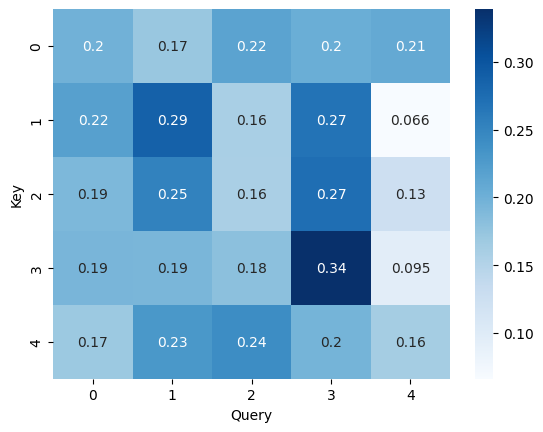

In [ ]:
# 첫번째해드 가중치 시각화 (쿼리와 키들의 어텐션 값)
import seaborn as sns
attn_weights = attn_weight[0,0].detach().cpu().numpy()
sns.heatmap(attn_weights, annot=True, cmap='Blues')
plt.xlabel('Query')
plt.ylabel('Key')
plt.show()

torch.Size([1, 5])
torch.Size([1, 5, 64])
샘플 출력 shpae : torch.Size([1, 5, 64])
어텐션 가중치 shape : torch.Size([1, 4, 5, 5])


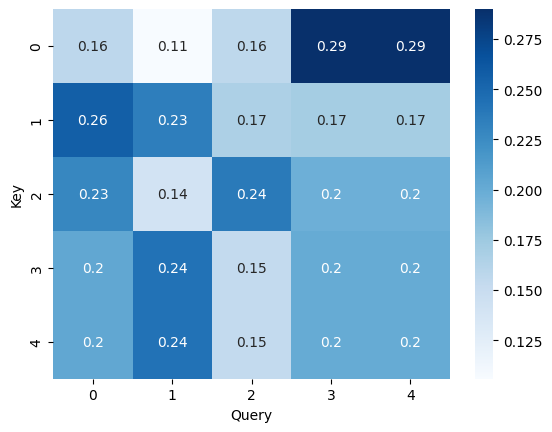

In [ ]:
# 실제 단어로 시뮬레이션
vocab = {'<PAD>':0,'<UNK>':1,'영화':2,'재밌다':3,'별로':4,'최고':5}
embedding_layer = nn.Embedding(len(vocab), embed_dim).to(device)
# 영화 재미있다 최고
sample_tokens = torch.LongTensor([[vocab['영화'] # 패딩 추가
                                  ,vocab['재밌다'],vocab['최고'],0,0 ]]).to(device)
print(sample_tokens.shape)
sample_embed = embedding_layer(sample_tokens)
print(sample_embed.shape)
# self attention 적용
out, attn_weight = model(sample_embed)
print(f'샘플 출력 shpae : {out.shape}')
print(f'어텐션 가중치 shape : {attn_weight.shape}')

# 첫번째해드 가중치 시각화 (쿼리와 키들의 어텐션 값)
import seaborn as sns
attn_weights = attn_weight[0,0].detach().cpu().numpy()
sns.heatmap(attn_weights, annot=True, cmap='Blues')
plt.xlabel('Query')
plt.ylabel('Key')
plt.show()

In [ ]:
attn_weights.sum(axis=1)

array([1.        , 1.        , 1.0000001 , 0.99999994, 0.99999994],
      dtype=float32)

Pretraining
```
MLM : Masked Laguage Nodel
  영화가 [mask] 재밌다
  특징 : 양방향 문맥,문장 전체를 보고 단어간 관계 학습
  용도 : 문맥이해가중요한 작업(감성분석, 질의응답)
CLM : Casual Laguage Nodel
  
```

Pretraining
```
MLM : Masked Laguage Model
  영화가 [mask] 재밌다
  특징 : 양방향 문맥,문장 전체를 보고 단어간 관계 학습
  용도 : 문맥이해가중요한 작업(감성분석, 질의응답)
  빈칸채우기로 문장의 전체 맥락을 이해
CLM : Casual Laguage Model
  이전단어들만 보고 다음단어를 예측: 영화가 매우-> 재밌다
  특징:단방향 문맥이해, 텍스트생성에 최적화
  용도 : 텍스트생성(챗봇,스토리생성)
  다음문장 예측하기
BERT vs GPT 학습방식
  BERT 방식 : MLM + NSP(Next Sequence Prediction) 문장의 일부를 마스크한다음 두 문장의 연결 여부 판단
  Transformer Encoder만사용 양방향 문맥학습
  용도 : 텍스트 분류, 질의응답,개체명 인식
  문장을 깊이 분석
GPT(Generative Pre-Trained Transfomer)
  CML : 이전단어로 다음 단어 예측
  Transformer Decoder만사용 , 단방향 학습
  텍스트생성, 대화, 스토리 작성
  창의적인 이야기를 이어간다
BERT는 문맥이해도 GPT 유연한 생성
  
```

In [ ]:
import torch
from transformers import BertTokenizer, BertForMaskedLM, GPT2Tokenizer, GPT2LMHeadModel
import pandas as pd
import numpy as np

In [ ]:
# 한글 Bert 와 한글 gpt-2 모델 및 토크나이져
bert_tokenizer = BertTokenizer.from_pretrained('klue/bert-base')
bert_model = BertForMaskedLM.from_pretrained('klue/bert-base')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
bert_model.to(device)
gpt_model.to(device)
# 샘플문장
sample_text = '영화가 매우 재미있다'
masked_text = '영화가 [MASK] 재미있다'
from typing import List, Dict
def predict_bert_maksed(text:str, top_k:int = 5) :
  inputs = bert_tokenizer(text, return_tensors='pt',padding=True
                          , truncation=True).to(device)

  mask_idx = torch.where(inputs['input_ids'] == bert_tokenizer.mask_token_id)[1].item()
  bert_model.eval()
  with torch.no_grad():
    outputs = bert_model(**inputs)
    logits = outputs.logits[0,mask_idx]
    probs = torch.softmax(logits,dim=-1)
    top_probs,top_ids =  torch.topk(probs,k=top_k)
  result = []
  for prob, idx in zip(top_probs, top_ids):
    token = bert_tokenizer.decode([idx.item()])
    result.append({'token':token,'prob':prob.item()})
  return result

bert_result = predict_bert_maksed(masked_text)
print(bert_result)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'token': '너무', 'prob': 0.5043820738792419}, {'token': '참', 'prob': 0.10569418221712112}, {'token': '진짜', 'prob': 0.0575430765748024}, {'token': '정말', 'prob': 0.03511859476566315}, {'token': '더', 'prob': 0.035070035606622696}]


In [ ]:
# 한글 gpt
from transformers import PreTrainedTokenizerFast
gpt_tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
            bos_token='</s>', eos_token='</s>', unk_token='<unk>',
            pad_token='<pad>', mask_token='<mask>')
gpt_model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
def predict_gpt_next(text:str, top_k:int=5):
  inputs = gpt_tokenizer(text,return_tensors='pt', padding=True, truncation=True).to(device)
  input_ids = inputs['input_ids']
  gpt_model.eval()
  with torch.no_grad():
    outputs = gpt_model(**inputs)
    logits =  outputs.logits[0,-1]
    probs = torch.softmax(logits,dim=-1)
    top_probs, top_ids = torch.topk(probs,k=top_k)
  results = []
  for prob, idx in zip(top_probs,top_ids):
    token = gpt_tokenizer.decode([idx.item()])
    results.append({'token':token,'prob':prob.item()})
  return results
gpt_result = predict_gpt_next(sample_text)
print(gpt_result)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'token': '면서', 'prob': 0.21409927308559418}, {'token': '라는', 'prob': 0.09803730994462967}, {'token': '!\n', 'prob': 0.06238093972206116}, {'token': '', 'prob': 0.05613355711102486}, {'token': '라고', 'prob': 0.052700772881507874}]


In [ ]:
sample_text = '이 영화는 정말 재미있고 친구나 가족과 함께 '
masked_text = '이 영화는 정말 재미있고 친구나 가족과 함께 [MASK] 추천합니다.'
print(predict_bert_maksed(masked_text))
print(predict_gpt_next(sample_text))

[{'token': '강력', 'prob': 0.37302467226982117}, {'token': '강력히', 'prob': 0.21866130828857422}, {'token': '적극', 'prob': 0.09216134995222092}, {'token': '간다면', 'prob': 0.04563971236348152}, {'token': '가면', 'prob': 0.032889608293771744}]
[{'token': '봤', 'prob': 0.44383004307746887}, {'token': '#', 'prob': 0.07271353155374527}, {'token': '<unk>', 'prob': 0.04385720193386078}, {'token': '뭔', 'prob': 0.04302525520324707}, {'token': '괜', 'prob': 0.03127119690179825}]


GPT-2, GPT-3
```
  구조 : Transfromer의 Deocoder만 사용 Masked Self-Attention 이전 단어만 참고 CLM
GPT-2
  레이어 수 12~48개
  파라메터 : 1.5G
  다양한 텍스트 생성기능, 한국어 지원 모델 skt/kogpt2-base-v2
GPT-3
  레이어 수 96개
  파라메터:175G
  대규모데이터로 학습, zero-shot, few-shot성능이 뛰어남
LayerNorm
  각 레이어의 출력을 정규화
Residual
  잔차의 합...
  입력을 이후 출력에 더함(정보손실방지)  
Attention Head      
  단어간 병렬계산(head의 갯수가 gpt2 12개, gpt3 96개)     
```

In [ ]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
def generate_text(prompt:str, max_length:int=50,temperature:float=1.0,
                  top_k:int=0, top_p:float=1.0,label=None):
  inputs = tokenizer(prompt, return_tensors='pt',padding=True
                     , truncation=True).to(device)
  input_ids = inputs['input_ids']
  outputs = model.generate(
    input_ids,
    max_length = max_length,
    temperature = temperature,  # 생성의 다양성(낮을수록 보수적)
    top_k = top_k if top_k > 0 else None, #상위 k개의 토큰
    top_p = top_p if top_p < 1.0 else None, # 누적 확률 p까지 고려
    do_sample = True,
    num_return_sequences = 1,
    pad_token_id = tokenizer.pad_token_id,
  )
  generated_token= tokenizer.decode(outputs[0],skip_special_tokens=True)
  with torch.no_grad():
    logits = model(input_ids).logits[0,-1] # 마지막 토큰의 로짓
    probs = torch.softmax(logits, dim=-1)
    top_probs, top_idx = torch.topk(probs,5)
    top_tokens = [tokenizer.decode([idx.item()]) for idx in top_idx]
  return{
      "text" : generated_token,
      "logits" : logits[:5].cpu().numpy(),
      "probs" : top_probs.cpu().numpy(),
      "top_tokens" : top_tokens,
      'label' : label
  }

In [ ]:
prompt = '영화 리뷰 : 이 영화는'
options = [
  {'prompt':prompt,'temperature':0.7,"top_k":0, "top_p":1.0,'max_length':50,"label":"t:0.7"},
  {'prompt':prompt,'temperature':1.2,"top_k":0, "top_p":1.0,'max_length':50,"label":"t:1.2"},
  {'prompt':prompt,'temperature':0.7,"top_k":50, "top_p":1.0,'max_length':50,"label":"top_k: 50"},
  {'prompt':prompt,'temperature':0.7,"top_k":0, "top_p":0.9,'max_length':50,"label":"top_k: 0.9"}
           ]

results = [ generate_text(**op) for op in options]

In [ ]:
for result in results:
  print(result['label'])
  print('생성 문장:',result['text'])
  print(f'마지막 토큰의 상위 5개')
  for token, prob in zip(result['top_tokens'],result['probs']):
    print(f'토큰:"{token}", 확률:{prob}')
  print(f'로짓(상위 5개) : {result["logits"]}')
  print('')

t:0.7
생성 문장: 영화 리뷰 : 이 영화는 최근 개봉한 영화 <시크릿 레코드>의 일부를 편집한 것입니다.
그런데 이 영화는 제목도 우리나라 영화 중에선 좀 특이한 영화인데, 영화 제목도 한국의 영화 중에선 좀 특이한 영화입니다.
우리가 흔히 생각하는
마지막 토큰의 상위 5개
토큰:",", 확률:0.014181885868310928
토큰:"'", 확률:0.01018199510872364
토큰:"201", 확률:0.009094958193600178
토큰:"한국", 확률:0.007404754403978586
토큰:"영화", 확률:0.007374824024736881
로짓(상위 5개) : [-4.746373  -4.7723937 -4.9847445 -6.2160587 -5.208909 ]

t:1.2
생성 문장: 영화 리뷰 : 이 영화는 강예지의 환상적인 연애 투성이 지금 벌어지고 있다. 적극적인 연애적인 남자 주의를 요란스럽게 사로잡는 다양한 남자 캐릭터, 이유일, 안영미, 최재천은 유능한 팀 보스 제대를 훌륭하게 헤쳐나간다. 방을 구
마지막 토큰의 상위 5개
토큰:",", 확률:0.014181885868310928
토큰:"'", 확률:0.01018199510872364
토큰:"201", 확률:0.009094958193600178
토큰:"한국", 확률:0.007404754403978586
토큰:"영화", 확률:0.007374824024736881
로짓(상위 5개) : [-4.746373  -4.7723937 -4.9847445 -6.2160587 -5.208909 ]

top_k: 50
생성 문장: 영화 리뷰 : 이 영화는 세계 최고 권위의 영화. #이브닝 #인친 #소통 #인친환영 #소통스타그램
#fff #follow #l
마지막 토큰의 상위 5개
토큰:",", 확률:0.014181885868310928
토큰:"'", 확률:0.01018199510872364
토큰:"201", 확률:0.009094958193600178
토큰:"한국", 확률:0.007404754

미니 GPT (Fine-tuning)
```
파인튜닝: 사전학습된모델을 특정 작업에 맞게 추가 학습
목표 : 모델이 도메인별(한국어 영화리뷰) 데이터에 적응해 더 적합 출력 생성
방법:
  full fine-tuning : 모든 파라메터를 업데이트,성능좋음
  parameter-Efficient Fine-tuning : 일부 파라미터만 수정(LoRA)
전략
  작은학습률: 사전 학습된 지식 보전
  적절한 데이터셋 : 적으면 과적합, 많으면 비용상승
  정규화:(Dropout, Weight Decay) 과적합방지 및 원활한 학습
Dataset
  전처리 : 토큰화, 패딩, 특수토큰 추가
직접학습루프 작성
  데이터로드
  옵티마이져
  손실함수
  학습루프
  등등..  
```

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from transformers import PreTrainedTokenizerFast
from transformers import GPT2LMHeadModel
from torch.utils.data import Dataset, DataLoader

In [ ]:
!wget http://skt-lsl-nlp-model.s3.amazonaws.com/KoBERT/datasets/nsmc/ratings_train.txt

--2025-04-28 05:11:06--  http://skt-lsl-nlp-model.s3.amazonaws.com/KoBERT/datasets/nsmc/ratings_train.txt
Resolving skt-lsl-nlp-model.s3.amazonaws.com (skt-lsl-nlp-model.s3.amazonaws.com)... 3.5.184.139, 3.5.188.18, 3.5.184.76, ...
Connecting to skt-lsl-nlp-model.s3.amazonaws.com (skt-lsl-nlp-model.s3.amazonaws.com)|3.5.184.139|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  18.6MB/s    in 0.7s    

2025-04-28 05:11:07 (18.6 MB/s) - ‘ratings_train.txt’ saved [14628807/14628807]



In [ ]:
df = pd.read_csv('ratings_train.txt', sep='\t')[:5000]
df.dropna(inplace=True)
texts = df['document'].tolist()

In [ ]:
# 데이터 셋
class NSMCDataSet(Dataset):
  def __init__(self,texts: list, tokenizer,max_length:int = 50) -> None:
    self.tokenizer = tokenizer
    self.max_len = max_length
    self.inputs = []
    for text in texts:
      input_ids = tokenizer(
          text,
          max_length = max_length,
          padding = 'max_length',
          truncation = True,
          return_tensors = 'pt'
      )
      self.inputs.append(input_ids)

  def __len__(self):
    return len(self.inputs)
  def __getitem__(self, index):
    input_ids = self.inputs[index]['input_ids'].squeeze()
    attention_mask = self.inputs[index]['attention_mask'].squeeze()
    return input_ids,attention_mask

In [ ]:
input_ids = tokenizer(
          texts[0],
          max_length = 50,
          padding = 'max_length',
          truncation = True,
          return_tensors = 'pt'
      )
input_ids # 3은 패딩

{'input_ids': tensor([[ 9050,  9267,  7700,  9705, 23971, 12870,  8262,  7055,  7098,  8084,
         48213,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [ ]:
# 모델 , 토크나이저 로드
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 데이터셋 및 데이터 로더 준비
dataset = NSMCDataSet(texts, tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
next(iter(dataloader))

[tensor([[16962,  8811, 24743, 43594,  9166,  9124,  9169,  7285,  9016,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3],
         [ 9150,  7592,  9668,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3],
         [ 9571,   437,   388, 11509,  7492,  7374, 15630,  7478, 40422,  7372,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3, 

In [ ]:
# 학습설정
optimizer = torch.optim.AdamW(model.parameters(), lr= 2e-5)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
#  학습루프
num_epochs = 5
for epoch in range(num_epochs):
  epoch_loss = 0.0
  for batch,attention_mask in dataloader:
    batch = batch.to(device)
    attention_mask = attention_mask.to(device)
    # 순전파(예측)
    outputs = model(input_ids=batch,labels=batch,attention_mask=attention_mask)
    loss = outputs.loss
    # 역전파
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    epoch_loss += loss.item()
  print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}")

Epoch 1/5, Loss: 1.8636864381857192
Epoch 2/5, Loss: 1.4739377127287867
Epoch 3/5, Loss: 1.217515018991769
Epoch 4/5, Loss: 0.9251512770835584
Epoch 5/5, Loss: 0.6487343858796567


In [ ]:
# 모델 저장
model.save_pretrained('nsmc_gpt2') # 모델만 저장하면 안됨
tokenizer.save_pretrained('nsmc_gpt2') # 토큰나이저도 저장 / 모델과 같은 이름으로

('nsmc_gpt2/tokenizer_config.json',
 'nsmc_gpt2/special_tokens_map.json',
 'nsmc_gpt2/tokenizer.json')

In [ ]:
# 모델 불러오기 및 생성 테스트
finetuned_model = GPT2LMHeadModel.from_pretrained('nsmc_gpt2')
finetuned_tokenizer = PreTrainedTokenizerFast.from_pretrained('nsmc_gpt2')

In [ ]:
# 생성 테스트
def generated_text(model, tokenizer,prompt:str
                   , max_length:int=50,temperature:float = 0.7)->str:
  model.eval()
  input_ids = tokenizer(prompt, return_tensors='pt',padding=True
                     , truncation=True).to(device)

  outputs = model.generate(
      input_ids['input_ids'],
      max_length = max_length,
      temperature = temperature,  # 생성의 다양성(낮을수록 보수적)
      do_sample=True,
      num_return_sequences = 1,
      pad_token_id = tokenizer.pad_token_id,
  )
  return tokenizer.decode(outputs[0],skip_special_tokens=True)

In [ ]:
finetuned_model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

In [ ]:
prompt = '이번주 로또 번호는'
generated_text = generated_text(finetuned_model,finetuned_tokenizer,prompt)
print(generated_text)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


이번주 로또 번호는 101, 이 주말 로또 추석 때 또 봤네;; 로또 3사 다 잘 만들었어. ᄏᄏᄏᄏ재밌게 잘 봤어. ᄏᄏᄏᄏᄏ


In [ ]:
# 생성될 단어의 확률
inputs = tokenizer(prompt, return_tensors='pt',padding=True,truncation=True).to(device)
with torch.no_grad():
   outputs = finetuned_model(**inputs)
   logits = outputs.logits[0,-1]
   probs = torch.softmax(logits, dim=-1)
   top_probs, top_ids = torch.topk(probs, 5)
   top_tokens = [  finetuned_tokenizer.decode([idx.item()]) for idx in top_ids]
print(f'마지막 토큰 로짓(상위 5개):{logits[:5].cpu().numpy()}')
for token, prob in zip(top_tokens, top_probs):
  print(f'토큰:{token}, 확률:{prob:.4f}')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


마지막 토큰 로짓(상위 5개):[-5.6866026 -7.0828223 -4.433782   1.9006023 -4.988313 ]
토큰:10, 확률:0.1256
토큰:9, 확률:0.1156
토큰:8, 확률:0.1093
토큰:7, 확률:0.0551
토큰:6, 확률:0.0532


텍스트 생성 모델 심화
```
Sampling 전략
  텍스트생성 핵심: 각 단계에서 다음 토큰을 예측
  Greedy Search:
    매번 가장 높은 확률의 토큰 선택
    빠르고 간단
    단점 : 창의성이 부족 ,결과가 단조롭다
  Beam Searh:
    상위 k개 시퀀스를 병렬로 추적, 최종적으로 최고 점수 스퀀스선택
    더 논리적이고 일관됨 문장
  Top-k-Sampling:
    상위 k개토큰중에 무작위
    창의성과 품질이 균형
  Temperature:
    로짓을 조정해서 확률분포변경
      낮은값 : 0.7 확률분포가 뽀족, 보수적
      높은값 : 1.2 확률분포 평평, 창의적/래덤 선택   
응용.스토리생성,스타일 변화
  스토리생성
    프롬프트(시작문장) 제공->모델이 이어서 이야기 생성
  스타일 변화
    모델이 특정 스타일(공식적, 캐주얼, 문학적)로 텍스트를 생성

```

In [ ]:
# 한글 gpt2 모델 과 토크나이져 로드
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
                  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
                  pad_token='<pad>', mask_token='<mask>')
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2').to(device)
# 문장 생성 함수
def generated_text(
    prompt:str,   # 입력 프롬프트
    max_length:int = 100,  # 최대 생성길이
    temperature: float=1.0,  # 생성 다양성(낮을수록 보수적)
    top_k:int=0,  # 상위 k개의 토큰만 고려
    top_p:float=1.0, # 누적확률 p까지 토큰 고려
    num_beams:int = 1, # Beam Searh의 빔수
    do_sample:bool=True # 샘플링 여부
    )->dict:  # 생성 텍스트와 마지막 토큰의 로짓/확률
  model.eval()
  input_ids = tokenizer(prompt, return_tensors='pt',padding=True
                     , truncation=True).to(device)
  # Greedy Searh인경우 do_sample=False, num_beams=1
  if num_beams == 1 and top_k ==0 and top_p == 1.0 and temperature == 1.0:
    do_sample = False
  input_ids = input_ids['input_ids']
  outputs = model.generate(
      input_ids,
      max_length = max_length,
      temperature = temperature,  # 생성의 다양성(낮을수록 보수적)
      top_k = top_k if top_k >0 else None,
      top_p = top_p if top_p < 1.0 else None,
      num_beams = num_beams,
      do_sample=do_sample,
      num_return_sequences = 1,
      pad_token_id = tokenizer.pad_token_id,
      no_repeat_ngram_size=2  # 반복방지
  )
  output_text = tokenizer.decode(outputs[0],skip_special_tokens=True)
  # 마지막 토큰의 로짓과 확률
  with torch.no_grad():
    logits = model(input_ids).logits[0,-1]  # 프롬프트의 마지막 토큰의 로짓
    probs = torch.softmax(logits / temperature, dim=-1)
    top_probs, top_ids =  torch.topk(probs, 5)
    top_tokens = [  tokenizer.decode([idx.item()])  for idx in top_ids ]
  return{
      'text': output_text
      ,'logits': logits[:5].cpu().numpy()
      ,'probs': top_probs.cpu().numpy()
      ,'top_tokens': top_tokens
  }

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [ ]:
prompt = '옛날의 한 마을에'
generated_text(prompt,temperature=0.9,top_k = 50)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'text': '옛날의 한 마을에 살고 있다.\n그러나 이것은 하나의 방문이지만, 이방인은 그의 이야기를 들어주는 것이 아니라 그의 말을 듣고 있는 것이다.\n아마 이 방문은 처음의 방문을 통해서만 가능했을 것이다.\n그것은 그가 지금까지 듣고 있던 이야기의 끝이며, 그 이야기에 나오는 이야기들 또한 그 이야기들을 읽는 것이었기 때문이다.\n그는 그 이야기를 듣고 있으며, 그의 이야기 속에 들어 있는 이야기를 읽고 있다.\n그는 이 이야기들로부터 이 이야기의 진실, 그리고 이 이야기에 나타난 이야기를 통하여, 자신이 알고 있는 이야기의 내용들을 말하고 있음을 알게 되었다.\n따라',
 'logits': array([-4.7084203, -5.9164786, -5.5396094, -5.503705 , -4.4116774],
       dtype=float32),
 'probs': array([0.0764983 , 0.0759229 , 0.04554147, 0.02945458, 0.01672325],
       dtype=float32),
 'top_tokens': ['사는', '살고', '있는', '살던', '도착']}

텍스트 요약
```
Extractive Summarization
  원문에서 중요한 문장/구절을 그대로 추출해 요약생성(뉴스기사에서 핵심문장 3개 선택)
  장점 : 구조간단
  단점 : 자연스럽지 않음

Abstractive Summarization
  원문의 의미를 이해하고 새로운 문장으로 재구성(뉴스기사를 한 문장으로 요약)
  장점 : 인간처럼 자연스러운 요약
  단점 : 의미 왜곡

GPT
  GPT계열은 CLM 기반, 텍스트 생성에 강함
  한계 : Decoder-only 모델, 요약처럼 입력 문맥을 깊이 이해하는데 약함
  비유 : gpt 이야기를 이어나가는 소설가, 요약은 전체를 분석하는 편집자역활
BERT
  encoder-decoder 문맥을 이해하는 최적화
평가방법
  ROUGE(Recall-Oriented Understudy for Gistion Evaluation)
    생성요약과 참조요약(정답) 간 단어/구문 중복 측정  
    종류
      ROUGE-N : N-gram 중복(1그램은 단어, 2그램은 단어쌍)
      ROUGE-L : 최장 공통부분열(LCS)기반, 문장구조 반영
      점수 : 0~1 높을수록 유사
      예측한 요약과 정답의 요약의 단어가 얼마나 일치하는지
      BLUE(Billingual Evaluation Understudy):
        생성과 참조간의 n-gram 정밀도
        기계번역에 주로 사용
        번역문과 원문의 단어 일치도 체크
```

In [ ]:
from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration
tokenizer =  PreTrainedTokenizerFast.from_pretrained("gogamza/kobart-summarization")
model = BartForConditionalGeneration.from_pretrained("gogamza/kobart-summarization")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BartTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


In [ ]:
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_lay

In [ ]:
# 샘플 뉴스 기사 및 참조 요약
nws_articles = [
    {
    'text': '''
      28일 오후 2시 1분께 대구 북구 노곡동 함지산에서 난 불이 바람을 타고 계속해서 확산하고 있다.
      산림 당국은 오후 3시 50분 현재 산불 대응 2단계를 발령하고 헬기 19대와 장비 38대, 인력 165명을 투입해 진화 작업을 벌이고 있다.
      산불 2단계는 예상 피해 면적이 50∼100㏊, 평균 풍속 7∼11m/s, 예상 진화 10∼48시간 미만일 때 발령된다.
        '''
    ,'reference_summary' : "대구 함지산에서 산불이 발생해 확산 중이다. 산림 당국은 대응 2단계를 발령하고 헬기 19대 등으로 진화 작업을 벌이고 있다."
    },
    {
        'text':'''도널드 트럼프 미국 대통령이 자동차 고율관세의 충격을 줄인다고 로이터 통신이 28일(현지시간) 보도했다.

보도에 따르면 미국 당국자들은 이 같은 조치가 미국 내에서 제조되는 자동차에 들어가는 외국산 부품에 대한 일부 관세를 완화하고 외국산 자동차에 여러 관세가 중첩되지 않도록 하는 방식으로 이뤄진다고 밝혔다.

이번 방침은 자동차 고율관세 때문에 생산과 경영에 차질을 빚을 수 있다는 미국 내 자동차 업계, 노동계의 의견을 받아들인 데 따른 것이다.


하워드 러트닉 미국 상무부 장관은 이날 성명을 통해 "트럼프 대통령은 국내 자동차 제조업체, 위대한 우리 미국 노동자들과 중요한 제휴관계를 구축하고 있다"고 말했다.

러트닉 장관은 "이번 합의는 국내에서 생산하는 업체들에 보상하고 미국에 투자하고 국내 제조를 늘리겠다는 약속을 표명한 업체들에게 발판을 마련해주는 방식으로 이뤄진 대통령 통상정책의 중대한 승리"라고 평가했다.''',
        'reference_summary':"도널드 트럼프 미국 대통령이 자동차 고율관세로 인한 충격을 줄이기 위해 일부 외국산 부품 관세를 완화하고 중복 관세를 방지하기로 했다. 이는 자동차 업계와 노동계의 우려를 반영한 조치다."
    }

]

In [ ]:
# 요약 생성 함수
import torch
def generate_summary(text:str, max_length:int = 50, min_length:int = 10) ->dict:
  model.eval()
  inputs = tokenizer(text, return_tensors='pt', max_length=1024, padding=True,truncation=True).to(device)
  # 요약생성
  summary_dis =  model.generate(
      inputs['input_ids'],
      max_length = max_length,
      min_length = min_length,
      num_beams=4,
      # length_pealty=2.0,
      early_stopping=True,
      # no_repeat_ngam_size=2
  )
  summary = tokenizer.decode(summary_dis[0],skip_special_tokens=True)
  with torch.no_grad():
    del inputs['token_type_ids']
    logits = model(**inputs).logits[0,-1]  # 마지막 토큰 로짓
    probs = torch.softmax(logits,dim=-1)
    top_probs, top_ids =  torch.topk(probs,5)
  return {'summary':summary,'logits':logits[:5].cpu().numpy()
  ,'probs':top_probs.cpu().numpy()
  ,'top_tokens' : [tokenizer.decode([idx.item()]) for idx in top_ids]
  }

In [ ]:
test_article = '''
SK텔레콤은 보안관제센터에서 데이터가 빠져나간 트래픽 이상을 감지한 18일 밤 11시 20분 과금 분석 장비에서 악성코드가 심어진 사실과 함께 파일을 삭제한 흔적을 발견했다.

이어 다음 날인 19일 오전 1시 40분 악성코드가 발견된 과금 분석 장비를 격리하고 침입 경로 및 유출 데이터 분석에 착수했다.

19일 오후 11시 40분 홈가입자서버(HSS)의 데이터 유출이 의심되는 정황을 확인했다.

이 서버는 4G 및 5G 가입자가 음성 통화를 이용할 때 단말 인증을 수행한다.

최 의원은 "국민 불안이 큰 만큼 SK텔레콤은 하루빨리 더 많은 양의 유심을 확보해 택배 운송 등 보다 적극적인 조치에 나서고 번호이동을 원하는 고객에 대해서는 위약금 면제 등 실질적 피해 구제 대책을 즉각 시행해야 한다"고 말했다.
'''
result = generate_summary(test_article)
print(result['summary'])
result

 SKSK텔레콤은 보안관제센터에서 데이터가 빠져나간 트래픽 이상을 감지한 18일 밤 11시 20분 과금 분석 장비에서 악성코드가 심어진 사실과 함께 파일을 삭제한 흔적을 발견했고, 다음 날


{'summary': ' SKSK텔레콤은 보안관제센터에서 데이터가 빠져나간 트래픽 이상을 감지한 18일 밤 11시 20분 과금 분석 장비에서 악성코드가 심어진 사실과 함께 파일을 삭제한 흔적을 발견했고, 다음 날',
 'logits': array([3.1775098, 9.248589 , 6.083553 , 6.063609 , 6.047577 ],
       dtype=float32),
 'probs': array([0.04558806, 0.0376569 , 0.03494328, 0.01233411, 0.01191952],
       dtype=float32),
 'top_tokens': ['말했다.', '밝히', '더불어민주당', '밝혔다.\n', '']}

In [ ]:
!pip install -q evaluate rouge-score
from evaluate import load
rouge = load('rouge')
reference = "SK텔레콤은 18일 밤 과금 분석 장비에서 악성코드와 파일 삭제 흔적을 발견하고, 19일 해당 장비를 격리했다. 이후 홈가입자서버(HSS)에서도 데이터 유출 의심 정황을 확인했다. 이에 대해 신속한 대응과 고객 보호 조치가 요구되고 있다."
# reference = [reference] * len(result['summary'])
results  = rouge.compute(predictions=[result['summary']],references=[reference]) # 값을 리스트에 넣어야함

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64

In [ ]:
results

{'rouge1': np.float64(0.25),
 'rouge2': np.float64(0.0),
 'rougeL': np.float64(0.25),
 'rougeLsum': np.float64(0.25)}